# K-Means Land Classification with Dask
A common machine learning approach to geospatial data is classifying land – this can be roughly estimated be using a K-Nearest Neighbours (KNN) model.  

In [ ]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer STAC server:
!pip install planetary_computer

In [154]:
import os
import rasterio
import rioxarray
import pystac
import stackstac
import datetime
import planetary_computer
import dask
import json
import gcsfs

import dask_ml.cluster

import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd

from skimage.exposure import rescale_intensity
from dask_gateway import Gateway
from shapely.geometry import Polygon
from pystac_client import Client

## 1. Initialize Dask Cluster

In [2]:
def register_gcsfs_client(username:str):
    # set up the gcsfs system with credentials
    print('registering gcsfs')
    tok = os.path.join(os.environ['HOME'], f'geoanalytics_{username}', 'geo.json') # Change this to your own cred file
    tok_dict = json.load(open(tok)) # cloudpickle will just send the path to tok, which the processing nodes can't see. Send json instead
    gcs = gcsfs.GCSFileSystem(token=tok_dict, access='read_write')
    return gcs

def register_dask_client(imgname:str=None):
    ''' Make the gcsfs filesystem available with credentials and start client '''
    # we want to set up a cluster
    client = None
    cluster = None
    print('registering cluster')
    gateway = Gateway()
    options = gateway.cluster_options()
    if not imgname is None:
        options.image = imgname
    cluster = gateway.new_cluster(options)
    print(cluster.name)
    client = cluster.get_client()
    client.restart() # flush nodes
    return client, cluster, options

In [3]:
username = input('Username: ')
gcs = register_gcsfs_client(username=username)
client, cluster, options = register_dask_client(imgname='pangeo/pangeo-notebook:2022.04.15')

Username:  bsmith


registering gcsfs
registering cluster
pangeo.8aa374537f8d48318b7dda8e11fa4391


In [4]:
cluster

In [5]:
cluster.scale(10)

## AOI

This AOI was generated from: https://www.keene.edu/campus/maps/tool/ 

In [6]:
polygon = {
  "coordinates": [
    [
      [
        -73.8847303,
        45.4294192
      ],
      [
        -73.883357,
        45.4445361
      ],
      [
        -73.9108229,
        45.4442049
      ],
      [
        -73.9120245,
        45.4263471
      ],
      [
        -73.8847303,
        45.4294192
      ]
    ]
  ],
  "type": "Polygon"
}
polygon

{'coordinates': [[[-73.8847303, 45.4294192],
   [-73.883357, 45.4445361],
   [-73.9108229, 45.4442049],
   [-73.9120245, 45.4263471],
   [-73.8847303, 45.4294192]]],
 'type': 'Polygon'}

In [7]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

,geometry
0,"POLYGON ((-73.88473 45.42942, -73.88336 45.444..."


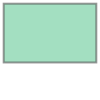

In [8]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [9]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

<Client id=microsoft-pc>

In [10]:
# CONFIG 
# -------------
TGT_BANDS =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEAR = '2021'
BEGIN_MONTH = '07'
END_MONTH = '08'
DATE_RANGE = f'{YEAR}-{BEGIN_MONTH}-01/{YEAR}-{END_MONTH}-30'
MAX_CLOUD = 5
READ_IN_CHUNK = 4096
RESOLUTION = 10
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
# -------------

In [11]:
items = api.search(
        collections = ['sentinel-2-l2a'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
        datetime = DATE_RANGE,
    ).get_all_items()
    
print(f'\tFound {len(items)} items')

	Found 1 items


In [13]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [17]:
# Data Stack

data = (
    stackstac.stack(
        signed_items,
        assets=TGT_BANDS, 
        chunksize=READ_IN_CHUNK, # Set chunksize
        resolution=RESOLUTION, # Set all bands res to this
        bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
    ).where(lambda x: x > 0, other=np.nan) # Convert nodata zero to np.nan
)
data

/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-8bd756e37c17913b8e3f30c37e9426bb' (time: 1,
                                                                band: 12,
                                                                y: 207, x: 228)>
dask.array<where, shape=(1, 12, 207, 228), dtype=float64, chunksize=(1, 1, 207, 228), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2021-08-03...
    id                                       (time) <U54 'S2A_MSIL2A_20210803...
  * band                                     (band) <U3 'B01' 'B02' ... 'B8A'
  * x                                        (x) float64 5.851e+05 ... 5.874e+05
  * y                                        (y) float64 5.033e+06 ... 5.031e+06
    constellation                            <U10 'Sentinel 2'
    ...                                       ...
    gsd                                      (band) float64 60.0 10.0 ... 20.0
    title                                    (band) <U37 'Band 1 - Coastal ae...
    common_name                              (band) object 'coastal' ... 'red...
    center_wavelength                        (band) float64 0.443 0.49 ... 0.865
    full_width_half_max                      (band) float64 0.027 ... 0.033
    epsg                                     int64 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(585080, 5030880, 587360, 5032...
    crs:         epsg:32618
    transform:   | 10.00, 0.00, 585080.00|\n| 0.00,-10.00, 5032950.00|\n| 0.0...
    resolution:  10

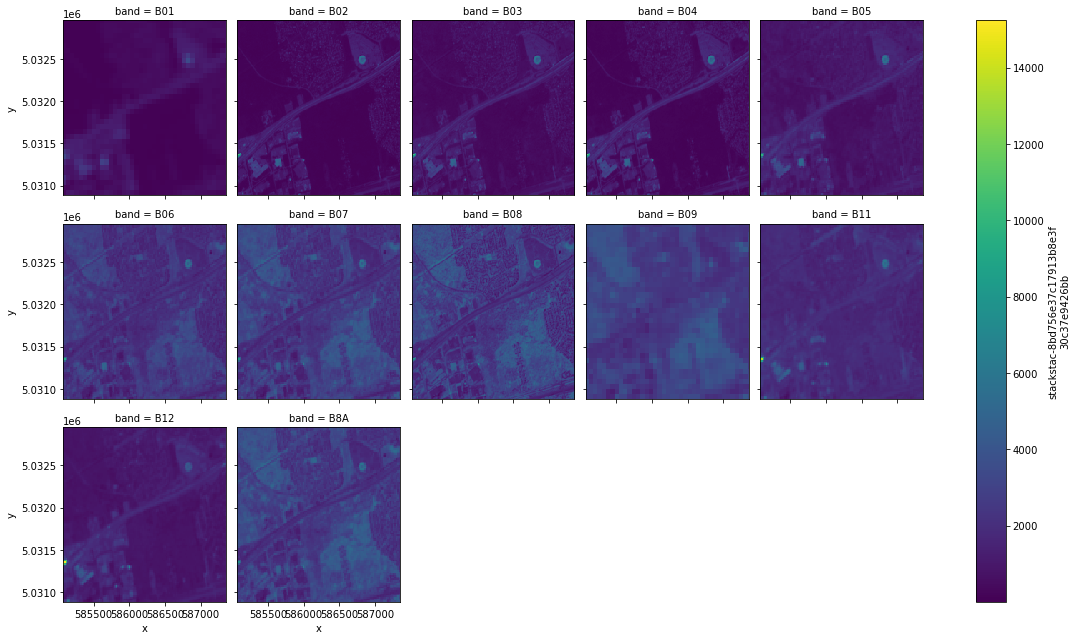

In [20]:
data[0].plot.imshow(x='x', y='y', col='band', col_wrap=5)

In [105]:
def normalize(array):
    norm = ((array - array.min()) / (array.max() - array.min())*255).astype(np.int8)
    return norm

In [106]:
data_norm = normalize(data)
data_norm

<xarray.DataArray 'stackstac-8bd756e37c17913b8e3f30c37e9426bb' (time: 1,
                                                                band: 12,
                                                                y: 207, x: 228)>
dask.array<astype, shape=(1, 12, 207, 228), dtype=int8, chunksize=(1, 1, 207, 228), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2021-08-03...
    id                                       (time) <U54 'S2A_MSIL2A_20210803...
  * band                                     (band) <U3 'B01' 'B02' ... 'B8A'
  * x                                        (x) float64 5.851e+05 ... 5.874e+05
  * y                                        (y) float64 5.033e+06 ... 5.031e+06
    constellation                            <U10 'Sentinel 2'
    ...                                       ...
    gsd                                      (band) float64 60.0 10.0 ... 20.0
    title                                    (band) <U37 'Band 1 - Coastal ae...
    common_name                              (band) object 'coastal' ... 'red...
    center_wavelength                        (band) float64 0.443 0.49 ... 0.865
    full_width_half_max                      (band) float64 0.027 ... 0.033
    epsg                                     int64 32618

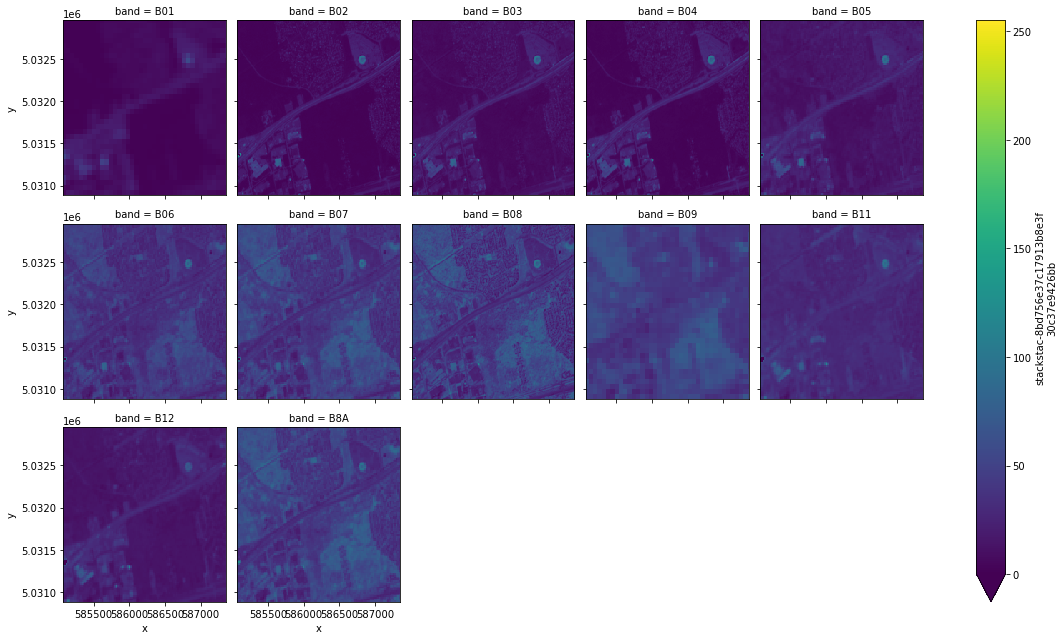

In [146]:
data_norm[0].plot.imshow(x='x', y='y', col='band', col_wrap=5, vmin=0, vmax=255)

In [108]:
km = dask_ml.cluster.KMeans(n_clusters=10, oversampling_factor=0)
km

KMeans(n_clusters=10, oversampling_factor=0)

In [109]:
arr_shape = data.shape
arr_shape

(1, 12, 207, 228)

In [110]:
arr = data_norm.data[0].reshape(arr_shape[1], arr_shape[2]*arr_shape[3]).T
arr

dask.array<transpose, shape=(47196, 12), dtype=int8, chunksize=(47196, 1), chunktype=numpy.ndarray>

In [111]:
arr_rc = arr.rechunk({1: arr.shape[1]})
arr_rc

dask.array<rechunk-merge, shape=(47196, 12), dtype=int8, chunksize=(47196, 12), chunktype=numpy.ndarray>

In [112]:
km.fit(arr_rc)

Found fewer than 10 clusters in init (found 1).


KMeans(n_clusters=10, oversampling_factor=0)

In [113]:
pred = km.predict(arr_rc)
pred

dask.array<astype, shape=(47196,), dtype=int32, chunksize=(47196,), chunktype=numpy.ndarray>

In [114]:
pred = pred.T.reshape(arr_shape[2], arr_shape[3])
pred

dask.array<reshape, shape=(207, 228), dtype=int32, chunksize=(207, 228), chunktype=numpy.ndarray>

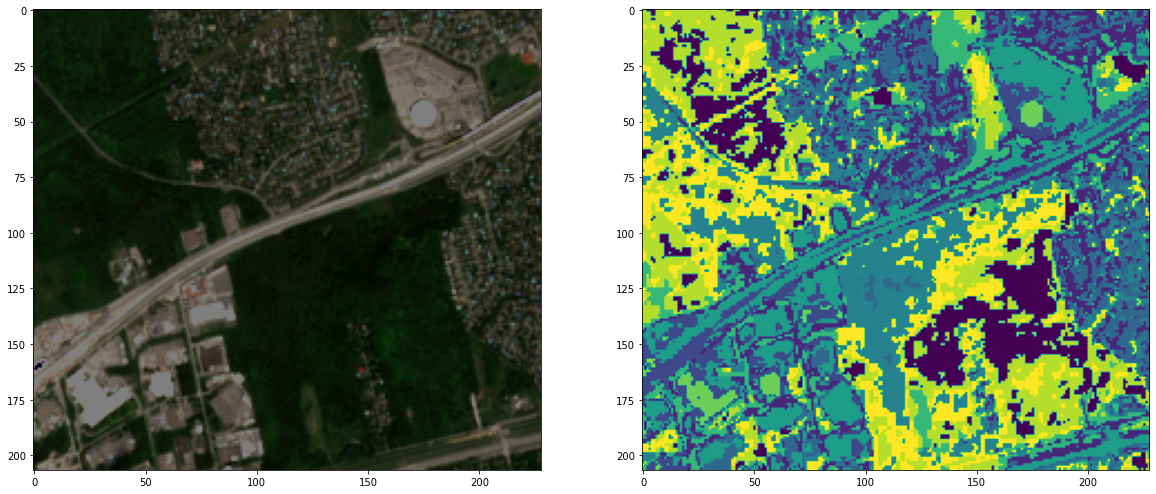

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(rescale_intensity(data_norm[0].sel(band=['B04','B03','B02']).data, in_range=(0,30)).transpose(1,2,0))
ax[1].imshow(pred)

In [ ]:
polygon = shapely.geometry.box(*bounding_box, ccw=True)
polygon

In [ ]:
fp = '/home/jovyan/geoanalytics_user_shared_data/CSA10332/caribou-aoi/GCBP_CARIB_polygon.shp'
gdf = gpd.read_file(fp)
gdf[gdf['CAR_TAG'] == 'Snake-Sahtaneh']

In [ ]:
def query_sentinel(username, password, footprint, start_date, end_date, max_cloud_cover):
    # Validate credentials for API access
    api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus')
    products = api.query(footprint,
                         date=(start_date, end_date),
                         platformname='Sentinel-2',
                         producttype='S2MSI1C',
                         cloudcoverpercentage=(0, max_cloud_cover))

    # Convert to Pandas DataFrame
    products_df = api.to_dataframe(products)
    # Remove rows with NaN for Tile ID and sort by ascending cloud cover
    df = products_df[products_df['tileid'].notna()].sort_values(['beginposition','cloudcoverpercentage'], ascending=[True,True])
    
    df = df.drop_duplicates(subset=['beginposition', 'tileid'], keep='first')
    

    # Only return dataframe with specific columns
    final_df = df[['title', 'beginposition', 'relativeorbitnumber', 'cloudcoverpercentage', 'tileid']].reset_index(drop=True)
    
    return final_df

In [ ]:
start_date = '20210501'
end_date = '20210730'
query_df = query_sentinel(secrets['SENTINELSAT_USER'], secrets['SENTINELSAT_PASS'], polygon, start_date, end_date, 30)

In [ ]:
query_df

In [ ]:
query_df['tileid'].unique()

In [ ]:
def get_sentinel_data(input_df, bands_wanted):
    # 1. Create dataframe to store the path to the granules we want
    df = pd.DataFrame()
    
    # 2. Iterate through the queried dataframe and store the file paths to the desired bands in a new dataframe. 
    for i,row in input_df.iterrows():
        # if row['relativeorbitnumber'] != 50:
        #     continue
        # Variables representing subdirectories to obtain the filepaths
        tile = row['tileid']
        title = row['title']
        img_title = row['title'][11:19]
        utm = tile[0:2]
        latitude = tile[2]
        direction = tile[3:5]
        dir_path = f'/home/jovyan/gcp-public-data-sentinel-2/L2/tiles/{utm}/{latitude}/{direction}/*{img_title}*/GRANULE/*'
        if not glob.glob(dir_path): # check if folder exists
            continue
        # Get SCL Mask
        scl_path = glob.glob(f'/home/jovyan/gcp-public-data-sentinel-2/L2/tiles/{utm}/{latitude}/{direction}/*{img_title}*/GRANULE/*/IMG_DATA/R20m/*SCL*.jp2') 
        if not scl_path: # check if SCL exists
            continue      
        scl_path[0] = scl_path[0].replace('/home/jovyan/','https://storage.googleapis.com/')
        
        row_dict = {'date': row['beginposition'], 
                    'cloud_cover' : row['cloudcoverpercentage'], 
                    'tile_ID': row['tileid'], 
                    'SCL': scl_path[0]}
        
        #Iterate through the list of input bands and store the filepath in a dictionary 
        for band in bands_wanted:
            filepath = glob.glob(f'{dir_path}/IMG_DATA/R10m/*{band}*.jp2')  
            filepath[0] = filepath[0].replace('/home/jovyan/','https://storage.googleapis.com/')
            row_dict.update({band:filepath[0]})
        # Add the dictionary as a dataframe row
        df = df.append(row_dict,ignore_index=True)

    return df

In [ ]:
bands_wanted = ['B02', 'B03', 'B04', 'B08']
df = get_sentinel_data(query_df, bands_wanted)

In [ ]:
df